In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('../Data/BrentOilPrices.csv')
data.head()

,Date,Price
0,20-May-87,18.63
1,21-May-87,18.45
2,22-May-87,18.55
3,25-May-87,18.60
4,26-May-87,18.63


In [3]:
data.shape

(9011, 2)

In [4]:
data.isnull().sum()

Date     0
Price    0
dtype: int64

In [5]:
data.dtypes

Date      object
Price    float64
dtype: object

In [6]:
data.describe()

,Price
count,9011.000000
mean,48.420782
std,32.860110
min,9.100000
25%,19.050000
50%,38.570000
75%,70.090000
max,143.950000


In [7]:
def format_date(date):
    formatted_date = pd.to_datetime(date, dayfirst=True, errors='coerce')
    
    if formatted_date.year < 1987:
        formatted_date = formatted_date.replace(year=2000 + formatted_date.year % 100)
    elif formatted_date.year < 2000:
        formatted_date = formatted_date.replace(year=1900 + formatted_date.year % 100)
        
    return formatted_date.strftime('%d-%m-%Y')
data['Date'] = data['Date'].apply(format_date)

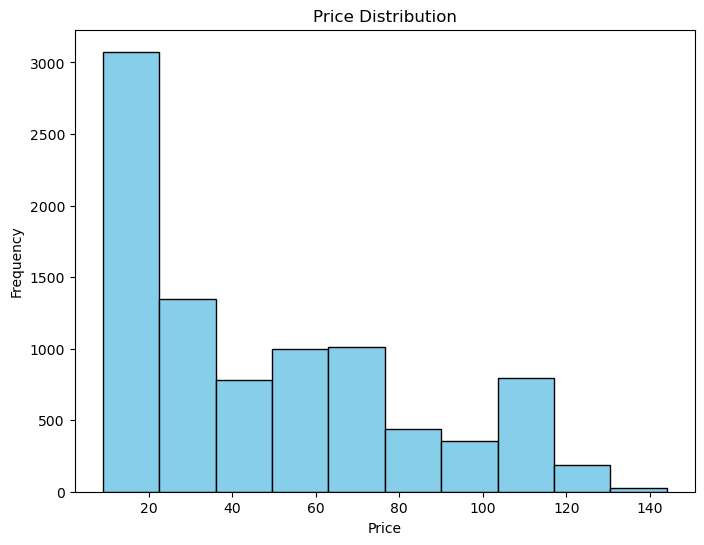

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
plt.hist(data['Price'], bins=10, color='skyblue', edgecolor='black')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

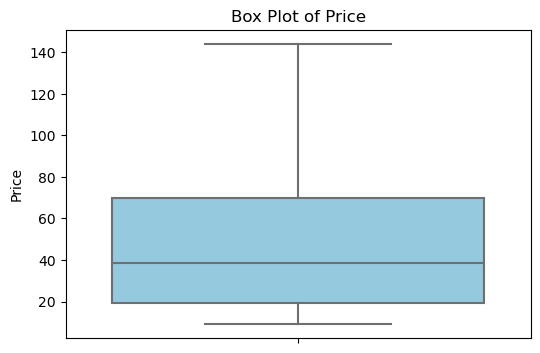

In [9]:
plt.figure(figsize=(6, 4))
sns.boxplot(y=data['Price'], color='skyblue')
plt.title('Box Plot of Price')
plt.ylabel('Price')
plt.show()


/tmp/ipykernel_10703/1907951762.py:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['Date']= pd.to_datetime(data['Date'])


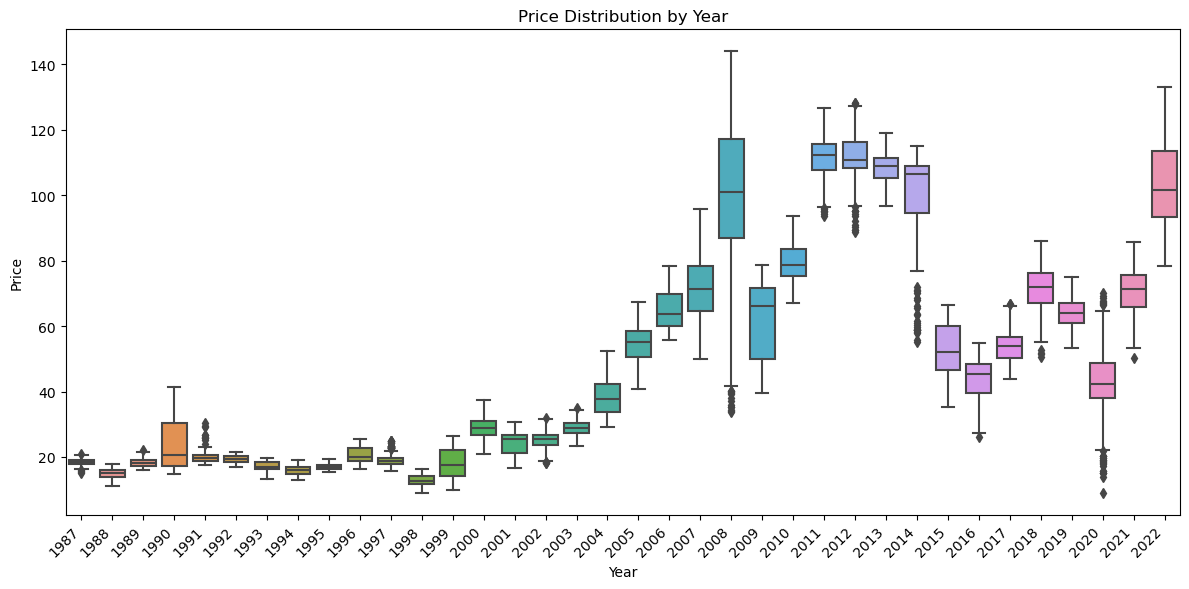

In [11]:
data['Date']= pd.to_datetime(data['Date'])
data['year'] = data['Date'].dt.year
plt.figure(figsize=(12, 6))
sns.boxplot(x='year', y='Price', data=data)
plt.title('Price Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Price')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 9011
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -14543.950
Date:                Mon, 04 Nov 2024   AIC                          29093.899
Time:                        15:26:36   BIC                          29115.218
Sample:                             0   HQIC                         29101.153
                               - 9011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3427      0.159     -2.152      0.031      -0.655      -0.031
ma.L1          0.3712      0.157      2.358      0.018       0.063       0.680
sigma2         1.4777      0.008    184.571      0.0

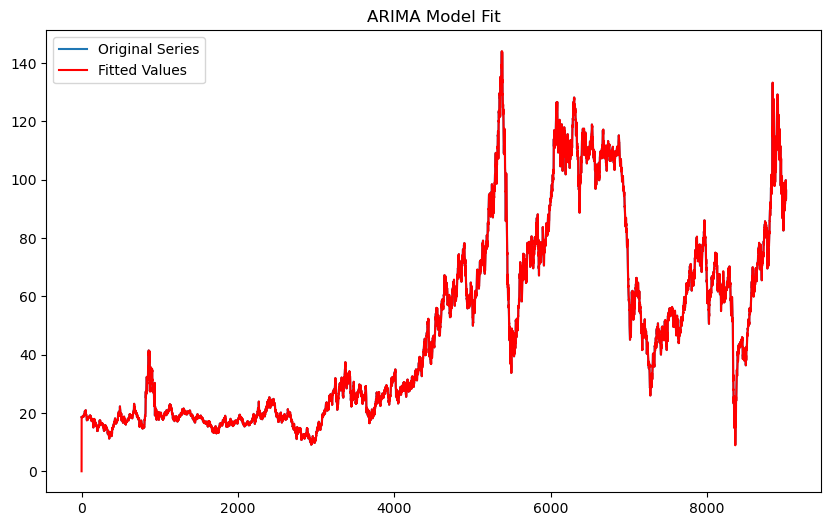

In [53]:
import statsmodels.api as sm
ts = pd.Series(data['Price'])
# Fit ARIMA model
model = sm.tsa.ARIMA(ts, order=(1, 1, 1)) 
model_fit = model.fit()

print(model_fit.summary())

# Plot the original series and the fitted values
plt.figure(figsize=(10, 6))
plt.plot(ts, label='Original Series')
plt.plot(model_fit.fittedvalues, color='red', label='Fitted Values')
plt.title('ARIMA Model Fit')
plt.legend()
plt.show()

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -35210.2
Distribution:                  Normal   AIC:                           70428.5
Method:            Maximum Likelihood   BIC:                           70456.9
                                        No. Observations:                 9011
Date:                Mon, Nov 04 2024   Df Residuals:                     9010
Time:                        16:06:12   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            18.6326  8.477e-02    219.801      0.000 [ 18.466, 18.79

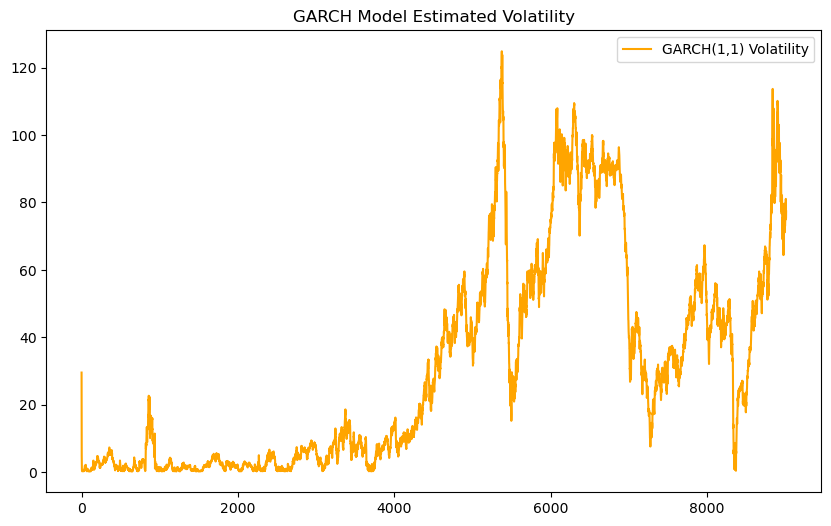

In [56]:
from arch import arch_model
ts = pd.Series(data['Price'])
# Fit GARCH model
garch_model = arch_model(ts, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')

print(garch_fit.summary())

# Plot the volatility
plt.figure(figsize=(10, 6))
plt.plot(garch_fit.conditional_volatility, label='GARCH(1,1) Volatility', color='orange')
plt.title('GARCH Model Estimated Volatility')
plt.legend()
plt.show()

In [24]:
data.index = pd.to_datetime(data['Date'])
data = data.drop('Date', axis=1)

/home/elizabeth/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 05, Nov, 2024
Time:                     12:13:39
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -5.07025
Nobs:                     9010.00    HQIC:                  -5.07337
Log likelihood:          -2700.48    FPE:                 0.00625120
AIC:                     -5.07498    Det(Omega_mle):      0.00624704
--------------------------------------------------------------------
Results for equation Price
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const           -8.030828         3.752861           -2.140           0.032
L1.Price         0.998399         0.000588         1698.915           0.000
L1.year          0.004049         0.001882            2.151           0.031

Res

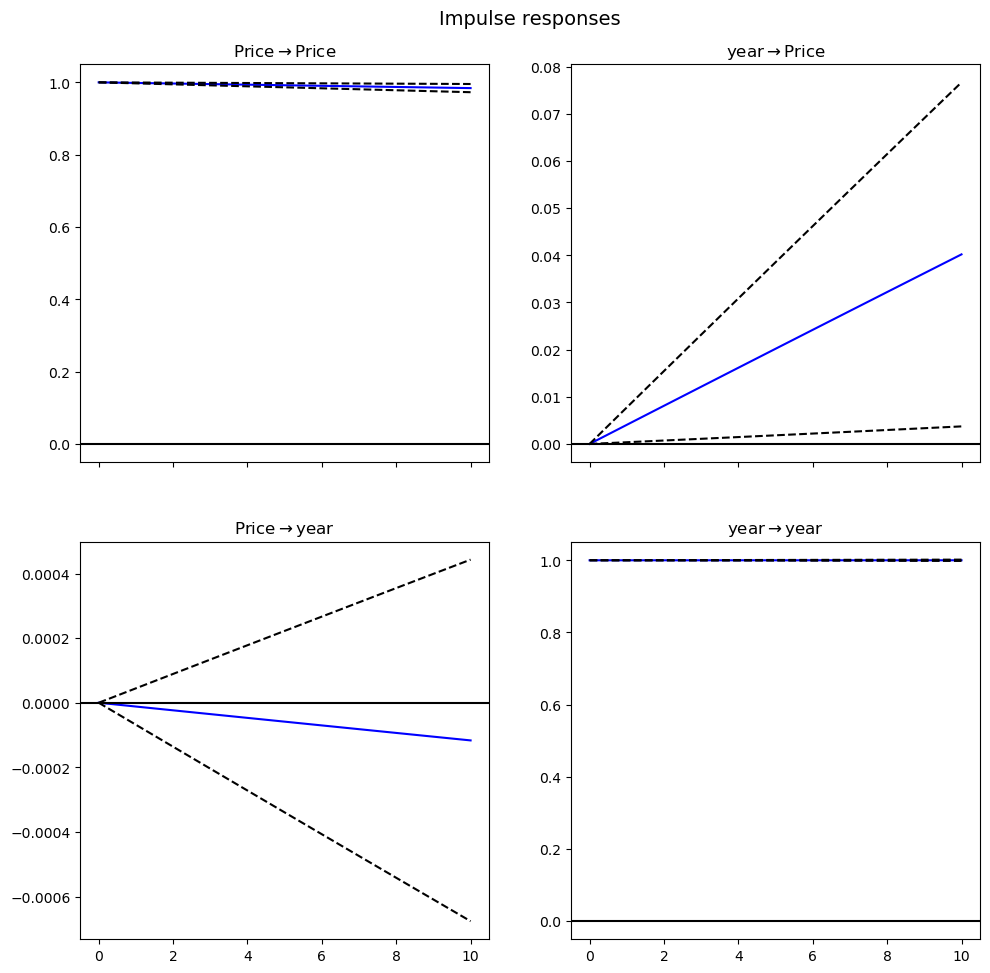

In [26]:
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.vecm import coint_johansen
# Fit the VAR model
model = sm.tsa.VAR(data)
results = model.fit(maxlags=4, ic='aic')

# Print the model summary
print(results.summary())

# impulse response functions
irf = results.irf(10)  # Generate 10-period impulse responses
irf.plot()

# Perform variance decomposition
fevd = results.fevd(10)  # Generate 10-period forecast error variance decomposition
print(fevd)

In [ ]:
# import statsmodels as sm
# from statsmodels.tsa.regime_switching.markov_switching import MarkovSwitching
# import pymc as pm
# prices = data['Price']
# num_regimes = 2
# # p, d, q = 1
# p = 1
# d = 1
# q = 1

# # Use an AR(1) model with regime switching
# ms_ar_model = MarkovSwitching(prices, k_regimes=num_regimes, order=1)
# ms_ar_result = ms_ar_model.fit()
# print(ms_ar_result.summary())

# #regime probabilities
# regime_probs = ms_ar_model.predict()
# print(regime_probs)

# import matplotlib.pyplot as plt

# plt.plot(prices.index, regime_probs)
# plt.title('Regime Probabilities')
# plt.xlabel('Date')
# plt.ylabel('Probability of Regime')
# plt.show()

In [22]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error

2024-11-05 22:25:24.472191: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-05 22:25:24.472597: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-05 22:25:24.811008: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-05 22:25:25.630823: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-05 22:25:40.031946: W tensorflow/compiler/tf2